# HVNM Tutorial 05: SAOS Linear Viscoelasticity — NLSQ to NUTS

**Fit dynamic moduli G'(ω), G''(ω) with the Hybrid Vitrimer Nanocomposite Model**

Small-amplitude oscillatory shear probes the linear viscoelastic spectrum:

$$G'(\omega) = G_P X(\phi) + G_E \frac{\omega^2 \tau_E^2}{1 + \omega^2 \tau_E^2} + G_I X_I \frac{\omega^2 \tau_I^2}{1 + \omega^2 \tau_I^2} + G_D \frac{\omega^2 \tau_D^2}{1 + \omega^2 \tau_D^2}$$

$$G''(\omega) = G_E \frac{\omega \tau_E}{1 + \omega^2 \tau_E^2} + G_I X_I \frac{\omega \tau_I}{1 + \omega^2 \tau_I^2} + G_D \frac{\omega \tau_D}{1 + \omega^2 \tau_D^2}$$

where $\tau_E = 1/(2k_{BER}^{mat})$, $\tau_I = 1/(2k_{BER}^{int})$, $\tau_D = 1/k_d^D$.

SAOS is the richest single protocol, constraining up to **7 parameters** including
nanoparticle effects (φ, β_I).

## Dataset
Epstein et al. metal-organic coordination network — G'(ω), G''(ω)

## Estimated Runtime
- NLSQ: ~10 s | NUTS: ~1 min (FAST_MODE) / ~10 min (production)

## 1. Setup

In [1]:
import sys
import time

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax openpyxl
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import HVNMLocal

jax, jnp = safe_import_jax()
verify_float64()

sys.path.insert(0, "../..")
from examples.utils.hvnm_tutorial_utils import (
    configure_hvnm_for_fit,
    get_bayesian_config,
    get_fast_mode,
    get_nlsq_values,
    get_output_dir,
    load_epstein_saos,
    plot_fit_comparison,
    plot_ppc,
    plot_saos_components,
    plot_trace_and_forest,
    print_convergence,
    print_parameter_table,
    save_figure,
    save_results,
    setup_style,
)

setup_style()
print(f"JAX {jax.__version__}, FAST_MODE: {get_fast_mode()}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX 0.8.3, FAST_MODE: True


## 2. Load Data and Apply QC

Protocol: oscillation
  Points: 19 / 19
  x range: [0.1008, 99.42]
  y range: [29, 3674]
  material: Metal-organic coordination network (Epstein et al.)
  source: Epstein et al. (JACS 2019)
  units_x: rad/s
  units_y: Pa
  note: Exchangeable metal-ligand bonds, structurally analogous to vitrimer BER


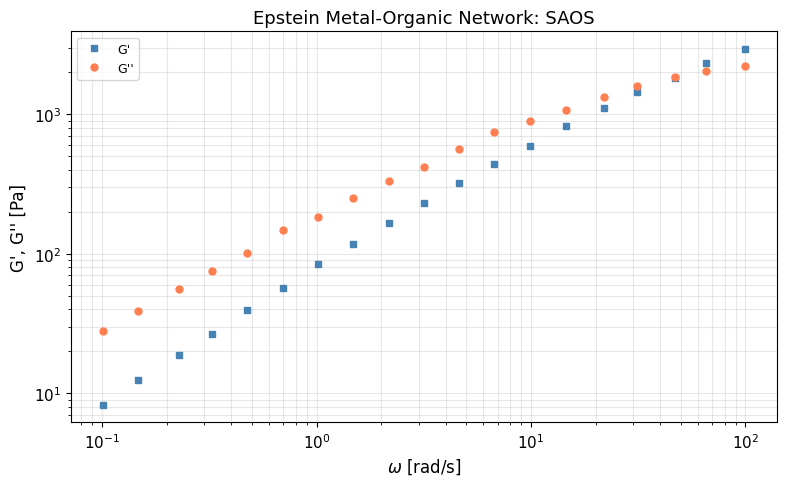

In [3]:
data = load_epstein_saos()

print(data.summary())

# Extract G', G'' for plotting
omega = data.x
G_prime = data.y2[:, 0]
G_double_prime = data.y2[:, 1]

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(omega, G_prime, 's', ms=5, color='steelblue', label="G'")
ax.loglog(omega, G_double_prime, 'o', ms=5, color='coral', label="G''")
ax.set_xlabel(r'$\omega$ [rad/s]')
ax.set_ylabel("G', G'' [Pa]")
ax.set_title('Epstein Metal-Organic Network: SAOS')
ax.legend()
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

In [4]:
# QC checks for SAOS
# Check for G'' > G' crossover (liquid-like to solid-like transition)
crossover_idx = np.where(np.diff(np.sign(G_prime - G_double_prime)))[0]
if len(crossover_idx) > 0:
    omega_cross = omega[crossover_idx[0]]
    print(f"G'/G'' crossover at omega ~ {omega_cross:.4g} rad/s")
    print(f"  => Dominant relaxation time ~ {1/omega_cross:.4g} s")
else:
    print("No G'/G'' crossover in measured range.")

# Low-frequency plateau (G_P indicator)
G_prime_low = G_prime[:3].mean()
print(f"\nLow-freq G' plateau ~ {G_prime_low:.4g} Pa")
print(f"  => Initial G_P guess: {G_prime_low:.4g} Pa")

# High-frequency limit
G_prime_high = G_prime[-3:].mean()
print(f"High-freq G' ~ {G_prime_high:.4g} Pa")
print(f"  => Sum of all moduli ~ {G_prime_high:.4g} Pa")

G'/G'' crossover at omega ~ 46.96 rad/s
  => Dominant relaxation time ~ 0.02129 s

Low-freq G' plateau ~ 13.16 Pa
  => Initial G_P guess: 13.16 Pa
High-freq G' ~ 2369 Pa
  => Sum of all moduli ~ 2369 Pa


## 3. Configure HVNM and Fit (NLSQ)

SAOS constrains the most parameters of any single protocol:
- **G_P, G_E, G_D**: Three moduli from the storage modulus spectrum
- **nu_0, k_d_D**: Two relaxation times from the loss peaks
- **phi, beta_I**: Nanoparticle effects (if data shows reinforcement)

For this pure polymer network (no NPs), we fix phi = 0 and fit 5 params.

In [5]:
model = HVNMLocal(include_dissociative=True)

# Use low-freq and high-freq limits for initial guesses
G_low = float(G_prime[:3].mean())
G_high = float(G_prime[-3:].mean())

fit_params = configure_hvnm_for_fit(
    model,
    protocol="oscillation",
    overrides={
        "G_P": G_low * 0.5,         # Plateau modulus
        "G_E": (G_high - G_low) * 0.5,
        "G_D": (G_high - G_low) * 0.3,
        "nu_0": 1e9,
        "k_d_D": 10.0,
        "T": 300.0,
        "phi": 0.0,        # No nanoparticles for this dataset
        "beta_I": 3.0,
    },
)

# For this NP-free dataset, remove phi and beta_I from fittable params
fit_params = [p for p in fit_params if p not in ('phi', 'beta_I')]
print(f"Fittable: {fit_params}")

t0 = time.time()
model.fit(
    data.x_masked,
    data.y_masked,
    test_mode="oscillation",
    use_log_residuals=True,
    max_iter=3000,
)
print(f"NLSQ: {time.time() - t0:.1f} s")

nlsq_vals = get_nlsq_values(model, fit_params)
for p, v in nlsq_vals.items():
    print(f"  {p} = {v:.4g}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Fittable: ['G_P', 'G_E', 'G_D', 'nu_0', 'k_d_D']


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.481234s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=5.6898 | elapsed=1.481s | final_gradient_norm=1.7755e+04


NLSQ: 2.0 s
  G_P = 6.58
  G_E = 1178
  G_D = 710.1
  nu_0 = 1e+09
  k_d_D = 43.54


Figure saved: /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../figures/hvnm/hvnm_05_saos_nlsq_Gstar.png


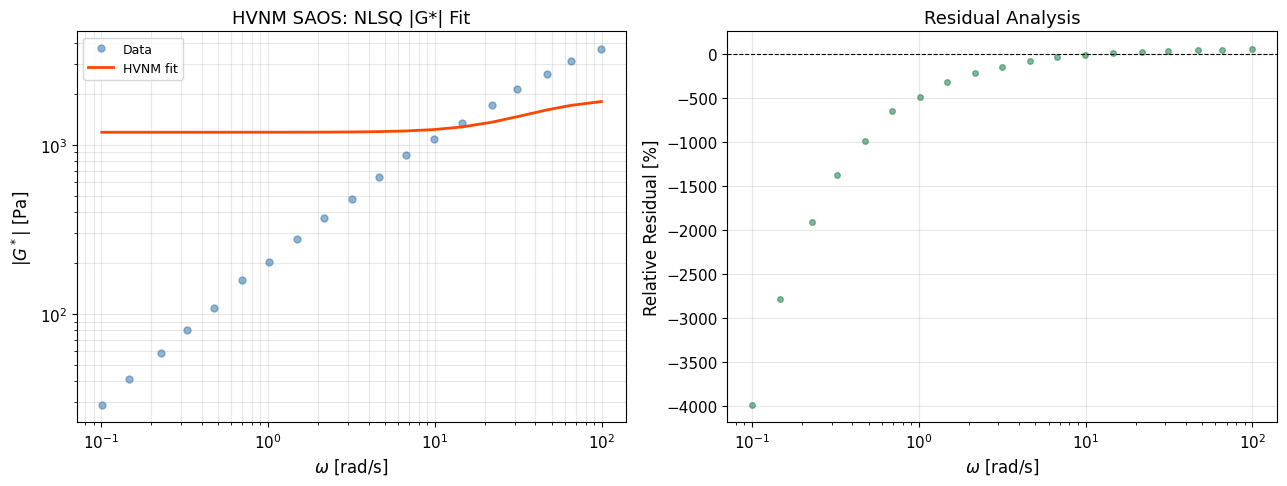

In [6]:
# Plot |G*| fit (what model_function returns)
fig = plot_fit_comparison(data, model, title="HVNM SAOS: NLSQ |G*| Fit")
save_figure(fig, "hvnm_05_saos_nlsq_Gstar.png")
plt.show()

Figure saved: /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../figures/hvnm/hvnm_05_saos_nlsq_components.png


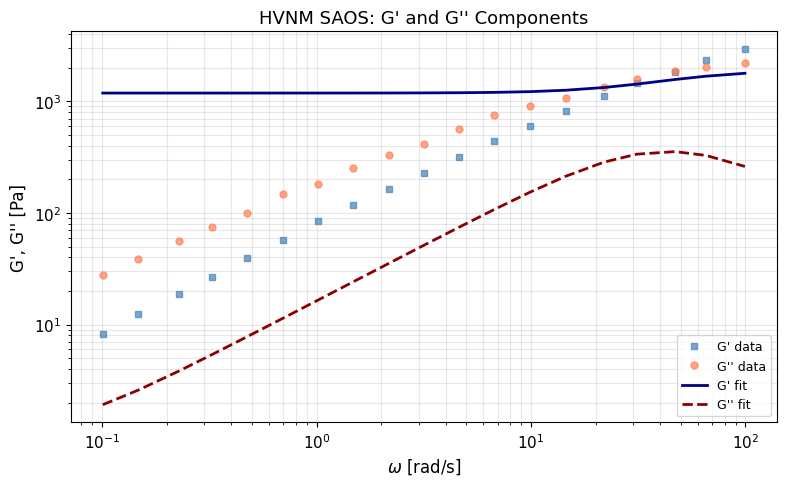

In [7]:
# Plot G' and G'' components separately
fig = plot_saos_components(data, model, title="HVNM SAOS: G' and G'' Components")
save_figure(fig, "hvnm_05_saos_nlsq_components.png")
plt.show()

## 4. Bayesian Inference (NUTS)

In [8]:
bayes_cfg = get_bayesian_config()
print(f"Config: {bayes_cfg}")

t0 = time.time()
result = model.fit_bayesian(
    data.x_masked,
    data.y_masked,
    test_mode="oscillation",
    **bayes_cfg,
)
print(f"NUTS: {time.time() - t0:.1f} s")

Config: {'num_warmup': 50, 'num_samples': 100, 'num_chains': 1}


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:01<03:19,  1.34s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:  17%|█▋        | 26/150 [00:01<00:05, 24.75it/s, 255 steps of size 4.53e-03. acc. prob=0.80]

warmup:  29%|██▊       | 43/150 [00:01<00:02, 42.27it/s, 255 steps of size 5.60e-03. acc. prob=0.83]

sample:  41%|████▏     | 62/150 [00:01<00:01, 63.44it/s, 255 steps of size 3.05e-03. acc. prob=0.85]

sample:  53%|█████▎    | 80/150 [00:01<00:00, 82.75it/s, 255 steps of size 3.05e-03. acc. prob=0.89]

sample:  66%|██████▌   | 99/150 [00:01<00:00, 102.81it/s, 255 steps of size 3.05e-03. acc. prob=0.89]

sample:  78%|███████▊  | 117/150 [00:01<00:00, 117.42it/s, 255 steps of size 3.05e-03. acc. prob=0.89]

sample:  90%|█████████ | 135/150 [00:02<00:00, 131.84it/s, 255 steps of size 3.05e-03. acc. prob=0.90]

sample: 100%|██████████| 150/150 [00:02<00:00, 69.50it/s, 255 steps of size 3.05e-03. acc. prob=0.90] 

NUTS: 5.1 s


## 5. Diagnostics and PPC

In [9]:
print_convergence(result, fit_params)
print()
print_parameter_table(fit_params, nlsq_vals, result.posterior_samples)

Convergence Diagnostics
   Parameter     R-hat       ESS
--------------------------------------------------
         G_P    1.0033        27 *
         G_E    1.1092        13 *
         G_D    1.0942        32 *
        nu_0    0.9948        16 *
       k_d_D    1.0994        38 *

Divergences: 0
Convergence: CHECK REQUIRED

Parameter Comparison
       Param          NLSQ    Bayes(med)                    95% CI
------------------------------------------------------------------
         G_P          6.58         50.55  [19.23, 80.92]
         G_E          1178     2.661e+06  [888.3, 4.23e+08]
         G_D         710.1          3438  [3301, 3582]
        nu_0         1e+09     3.856e+13  [6.927e+12, 8.023e+13]
       k_d_D         43.54         68.88  [61.9, 75.75]


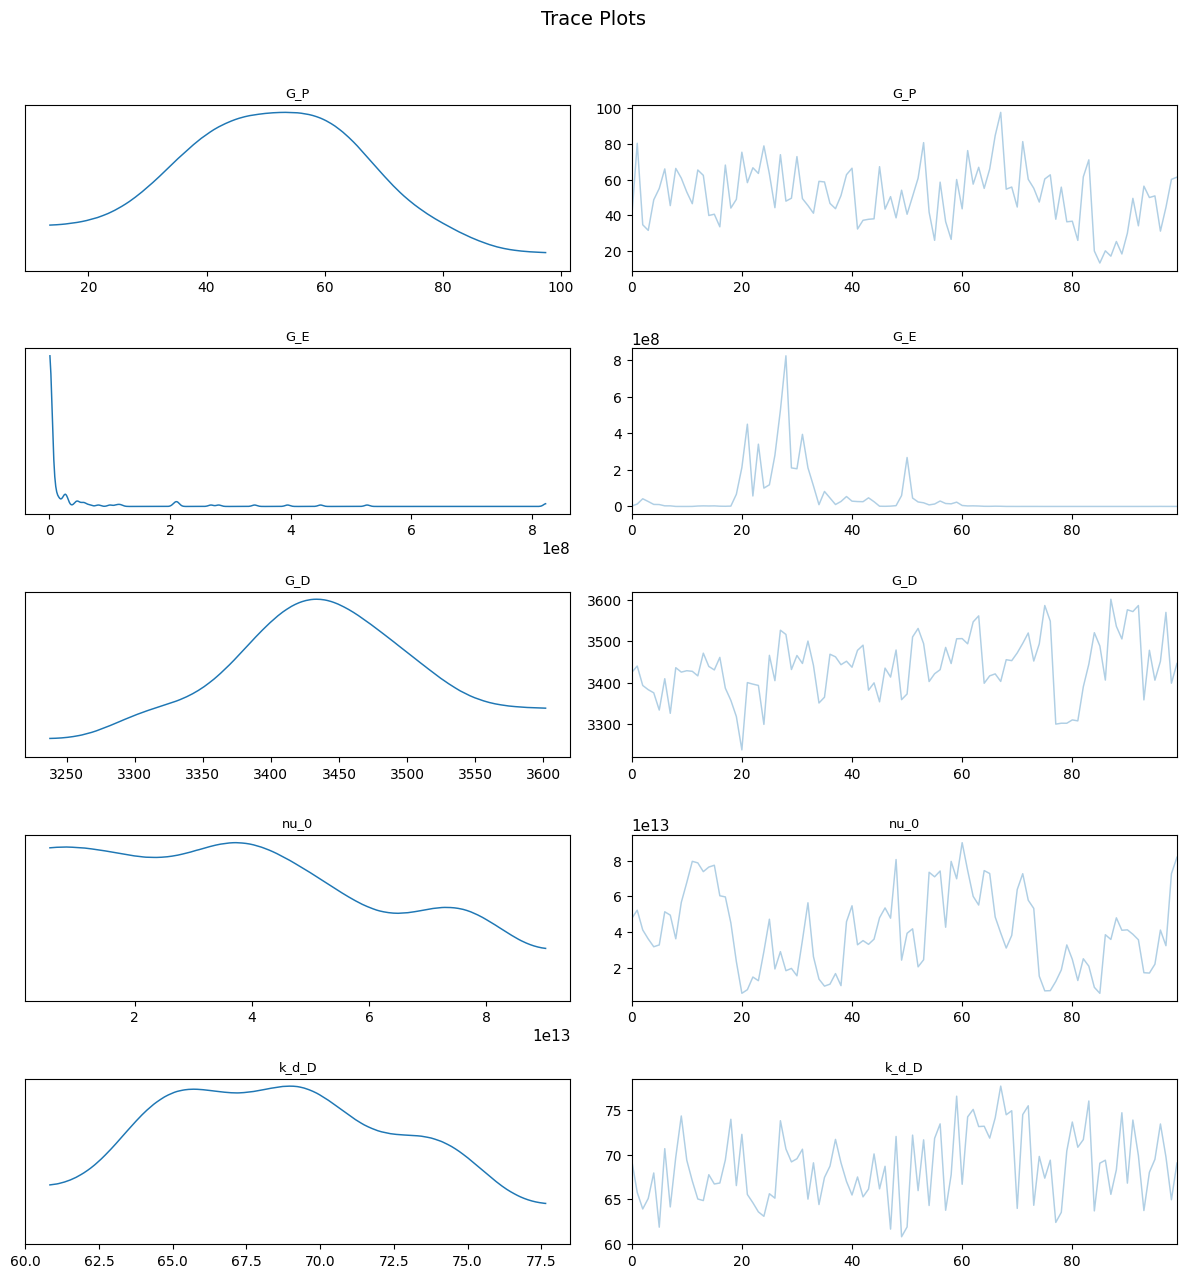

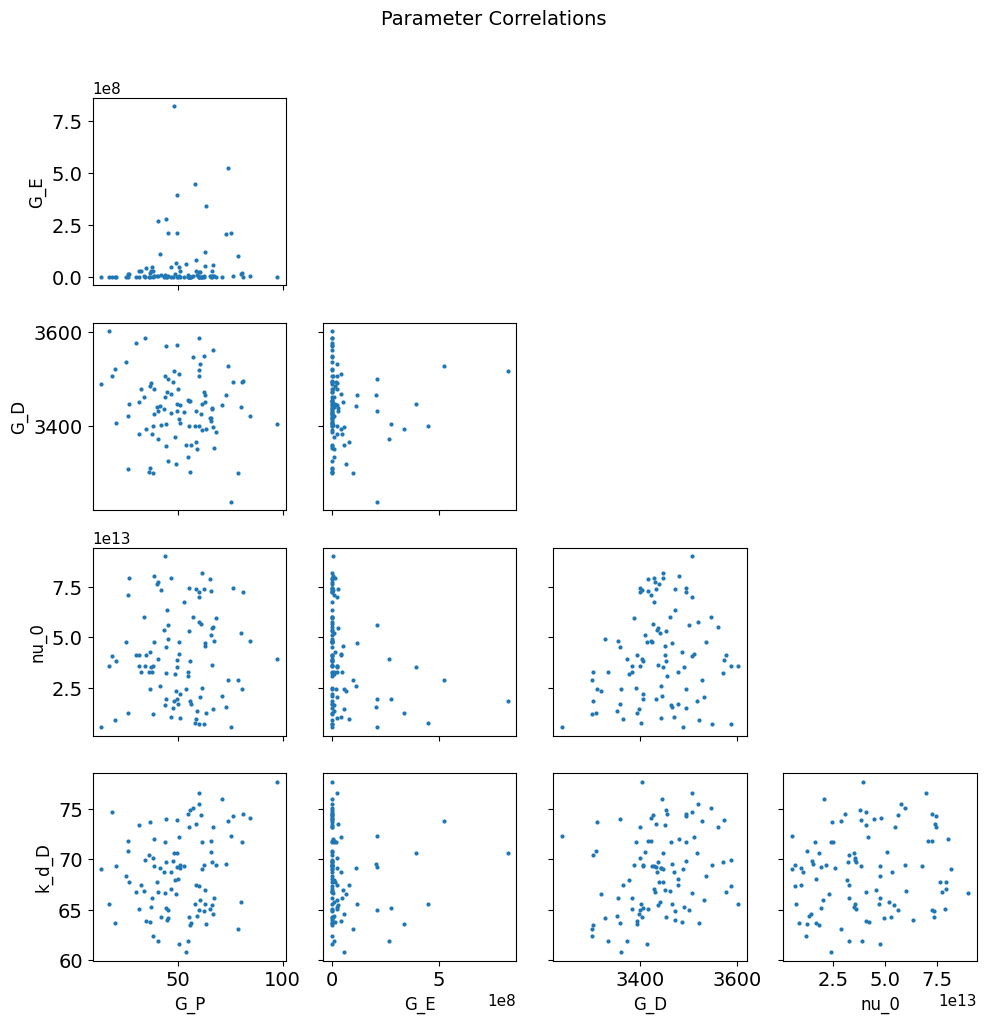

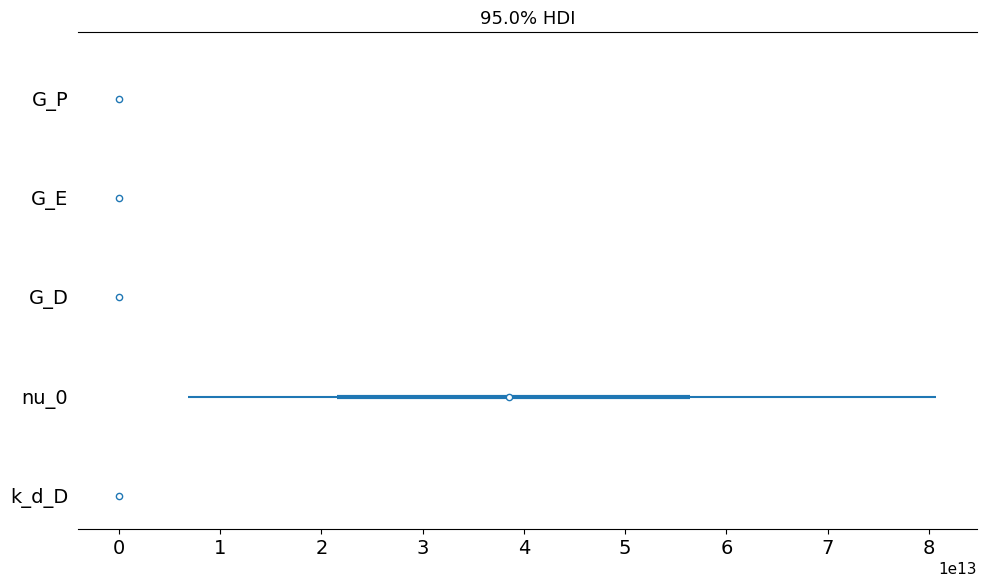

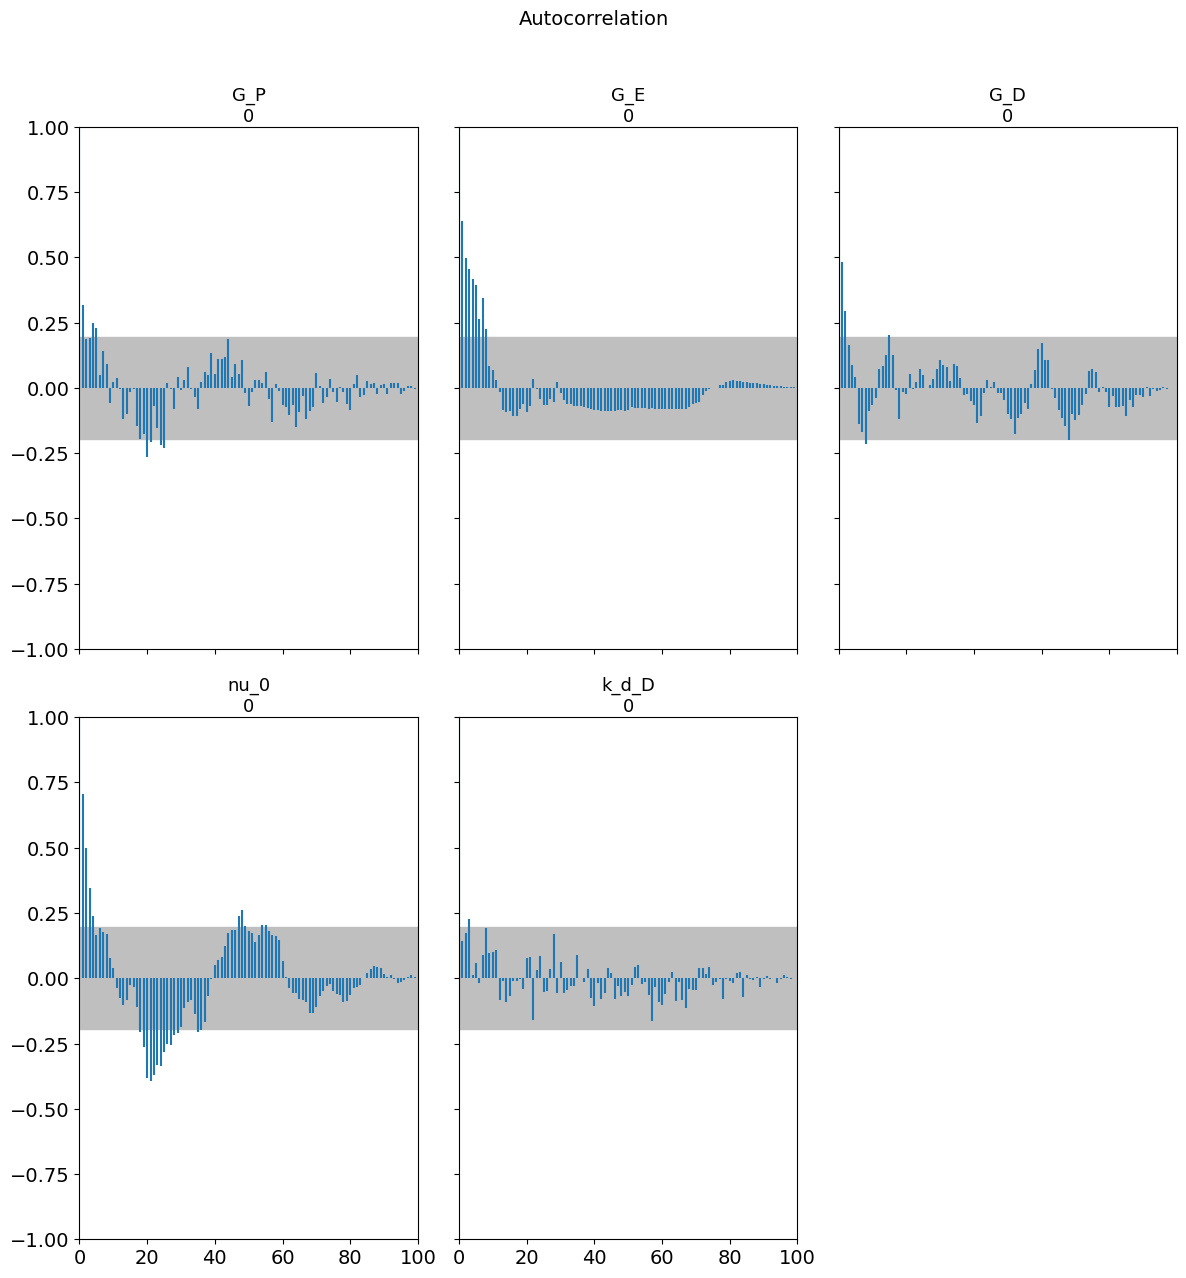

In [10]:
display_arviz_diagnostics(result, fit_params, fast_mode=get_fast_mode())

Figure saved: /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../figures/hvnm/hvnm_05_saos_ppc.png


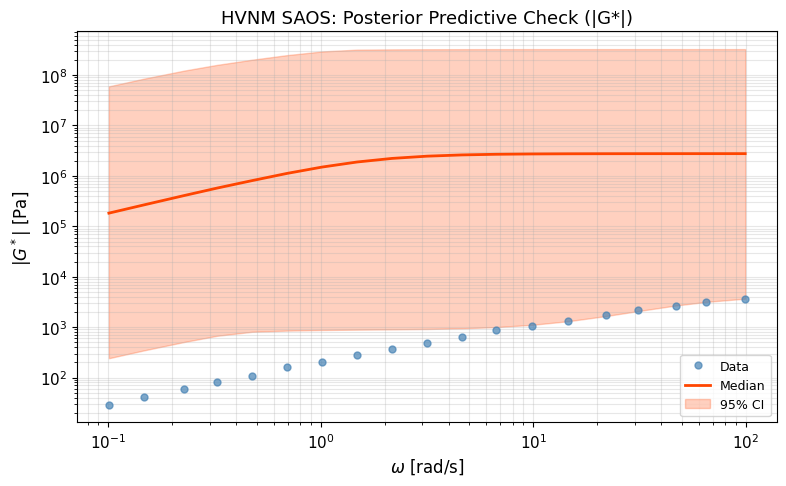

In [11]:
fig = plot_ppc(
    data, model, result.posterior_samples, fit_params,
    title="HVNM SAOS: Posterior Predictive Check (|G*|)",
)
save_figure(fig, "hvnm_05_saos_ppc.png")
plt.show()

## 6. Save Results

In [12]:
save_results(
    get_output_dir("saos"), model, result,
    param_names=fit_params,
    extra_meta={"dataset": "Epstein_JACS2019", "protocol": "oscillation"},
)

Saved to /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../outputs/hvnm/saos/


## What to Change for Your Data

1. **G* vs G',G''**: `model_function` returns |G*|. For separate G',G'' fitting, use `predict_saos()` directly
2. **Nanocomposites**: Uncomment phi and beta_I from `fit_params` for NP-filled materials
3. **Frequency range**: Wider ranges better constrain multiple relaxation times
4. **Temperature**: Metal-organic networks have different E_a than typical vitrimers. Adjust initial guesses

## Troubleshooting

- **G'/G'' mismatch**: SAOS fit uses |G*| for NLSQ/NUTS. If G' fits but G'' doesn't, check relaxation time initial guesses
- **Flat G' spectrum**: Material may be a simple elastic solid (G_E, G_D ~ 0). Try setting these to small values and fixing them
- **Too many free params**: 7 free params can be poorly constrained from a narrow frequency range. Fix phi=0 (as done here) for unfilled materials
- **Multiple crossovers**: If G'/G'' crosses multiple times, the HVNM tri-exponential spectrum is well-suited. Adjust initial relaxation times to bracket each crossover
- **nu_0 and k_d_D confused**: nu_0 sets the E-network time, k_d_D the D-network time. Initial guesses should place them near observed loss peaks